# Lab03

Model evaluation, testing, and calibration

<div class="alert alert-warning">
If figures/tables are not rendered correctly, make sure your notebook is `trusted` by choosing `Trust Notebook` command found in `View` - `Activate Command Palette` menu. Typing in the first letters (i.e. "tr") should give you the command.
</div>

<div class="alert alert-info">
This is a student version of the notebook that some portions of code are redacted with comments like `#= .. =#`. Students are encouraged to complete the code to get same/similar results as rendered in the notebook. You may submit a complete notebook as your homework assigment. An instructor version of the notebook will be provided once the lab session is finished each week.
</div>

In [1]:
using Cropbox

In [2]:
new_install = false
if new_install
    import Pkg
    Pkg.add("CSV")
    Pkg.add("DataFrames")
    Pkg.add("DataFramesMeta")
    Pkg.add("StatsBase")    
    Pkg.add("Dates")
#pkg"add DataFrames DataFramesMeta StatsBase CSV"
end

If you get errors running the cell below, some or all of the packages may not have been installed. In that case, change `new_install` to be `true` and run the cell abov to add those packages to the current kernel running in this environment.  

In [3]:
using DataFrames
using DataFramesMeta
using StatsBase
using CSV
using Dates

## Ex 3.1.

In this exercise, we will calibrate the logistic [Eqn 3.3] and Gompertz [Eqn 3.4] growth functions using experimental data from field corn research.

1. Calibrate the integral form of the logistic equation against the corn total shoot biomass data collected over time. What are your starting values for the parameters?
2. Do the same with the integral form of the Gompertz equation. What are your starting values for the parameters?
3. Evaluate the performance of the two models and determine which model fits data better. Use appropriate statistics as needed. Which model was easier with more interpretable parameters for you to determine their starting values?
4. Plot predicted vs observed values for both models and compare
5. Choose a function and use is to calibrate the biomass of each part (e.g., leaf, stem, and ear)

### Dataset

We can load CSV files into a table-like structure (`DataFrame`) using [CSV.jl](https://github.com/JuliaData/CSV.jl) package.

Cropbox additionally provides a convenience feature with `unitfy()` function that automatically handle units for each column. For example, if the column name was set to "LA (cm^2)" in the CSV file, it would be converted to a column named "LA" and its underlying type incorprating units of "cm^2".

Note that we used piping operator (`|>`) to hand over the data frame returned by `CSV.read()` to `unitfy()` function. It's identical as if we called `unitfy(CSV.read(...))`.

In [4]:
corn = CSV.read("corn_sample.csv", DataFrame) |> unitfy

111×17 DataFrame
 Row │ year   jday   day         SampleNo  Stage     Ht         Diameter    To ⋯
     │ Int64  Int64  Date        Int64     String3?  Float64?   Quantity…?  In ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  2002    162  2002-06-11         1  V5             48.0     missing     ⋯
   2 │  2002    162  2002-06-11         2  V5             44.0     missing
   3 │  2002    162  2002-06-11         3  V5             40.0     missing
   4 │  2002    162  2002-06-11         4  V5             49.5     missing
   5 │  2002    162  2002-06-11         5  V5             51.5     missing     ⋯
   6 │  2002    162  2002-06-11         6  V5             48.5     missing
   7 │  2002    162  2002-06-11         7  V5             49.0     missing
   8 │  2002    162  2002-06-11         8  V5             40.5     missing
   9 │  2002    162  2002-06-11         9  V4             39.0     missing     ⋯
  10 │  2002    162  2002-06-11        10  V5             51.0     missing
  11 │  2002    170  2002-06-19         1  V6             84.5     23.0 mm
  ⋮  │   ⋮      ⋮        ⋮          ⋮         ⋮          ⋮          ⋮          ⋱
 102 │  2002    261  2002-09-18         1  missing   missing       missing  mi
 103 │  2002    261  2002-09-18         2  missing   missing       missing  mi ⋯
 104 │  2002    261  2002-09-18         3  missing   missing       missing  mi
 105 │  2002    261  2002-09-18         4  missing   missing       missing  mi
 106 │  2002    261  2002-09-18         5  missing   missing       missing  mi
 107 │  2002    261  2002-09-18         6  missing   missing       missing  mi ⋯
 108 │  2002    261  2002-09-18         7  missing   missing       missing  mi
 109 │  2002    261  2002-09-18         8  missing   missing       missing  mi
 110 │  2002    261  2002-09-18         9  missing   missing       missing  mi
 111 │  2002    261  2002-09-18        10  missing   missing       missing  mi ⋯
                                                  10 columns and 90 rows omitted

There are many columns in the data frame as we can see with `names()` function.

In [5]:
names(corn)

17-element Vector{String}:
 "year"
 "jday"
 "day"
 "SampleNo"
 "Stage"
 "Ht"
 "Diameter"
 "TotLfNo"
 "LA"
 "StemDW"
 "LfDW"
 "EarDW"
 "Green"
 "LfNo"
 "DAS"
 "shootDW"
 "SLA"

`DAS` means "days after sowing". We have dry weights (DW) for shoot (`shootDW`), stem (`StemDW`), leaf (`LfDW`), and ear (`EarDW`).

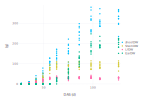

In [6]:
visualize(corn, :DAS, [:shootDW, :StemDW, :LfDW, :EarDW])

Among them, we'll first use shoot dry weight (`shootDW`) to calibrate the logistic growth model we learned last week.

### Logistic Equation

- Eqn 3.3.

$$
W = \frac{W_f}{1 + (\frac{W_f}{W_0} - 1) e^{-rt}}
$$

- Table 3.1.

| Symbol | Value | Units | Description |
| :- | :- | :- | :- |
| $t$ | - | $\mathrm{d}$ | Time unit used in the model |
| $r$ | - | $\mathrm{g}$ $\mathrm{g^{-1}}$ $\mathrm{d^{-1}}$ | Relative (or specific or intrinsic) growth rate |
| $W_0$ | - | $\mathrm{g}$ | Seed mass or initial biomass |
| $W_f$ | - | $\mathrm{g}$ | Potential final mass of a plant |
| $W$ | - | $\mathrm{g}$ | Whole-plant biomass as dry matter (state variable) |

Here is the logistic growth model we're going to use for modeling biomass accumulation. It's basically the same as the system `Eq25` we used last week.

Note that there are two ways of using exponential function in Julia. The first one is to use `exp()` function and the other is to use constant variable `ℯ` representing Euler's number with power operator `^` . To get the Unicode symbol `ℯ`, type `\euler` or first few letters like `\eu` and press tab key. `exp(-r*t)` would be equivalent to `ℯ^(-r*t)`.

In [7]:
@system Logistic(Controller) begin
    t(context.clock.time) ~ track(u"d")
    
    r:  relative_growth_rate    ~ preserve(parameter, u"g/g/d")
    W0: initial_biomass         ~ preserve(parameter, u"g")
    Wf: potential_final_biomass ~ preserve(parameter, u"g")
    
    W(t, r, W0, Wf): biomass => begin
        Wf / (1 + ((Wf / W0) - 1) * ℯ^(-r*t))
    end ~ track(u"g")
end

Logistic

Cropbox provides `calibrate()` function to find out a set of parameters best describing the dataset it's provided with. Internally, it relies on [BlackBoxOptim.jl](https://github.com/robertfeldt/BlackBoxOptim.jl) for global optimization methods. If you're interested in local optimization methods, refer to [Optim.jl](https://github.com/JuliaNLSolvers/Optim.jl) package for more information.

`calibrate()` is in a form like `calibrate(<System>, <DataFrame>; index=<..>, target=<..>, parameters=<..>, metric=<..>, optim=(; <BlackBoxOptim options>..), <simulate() options>..`. It acceps arguments similar to `simulate()` for setting up simulations. Then it also requires a data frame for ground truth data and their column names for `index` and `target` variables. Oftentimes, it is in a time series like how our dataset is recorded for corn harvest measurements. `parameters` are in a format similar to Cropbox configuration object except that each variable has a tuple of values specifying lower and upper bounds of the parameter instead of an actual value.

In this case, we're calibrating three parameters, `r`, `W0`, and `Wf`, within a reasonable range of values. We use same period of simulation, 150 days, as `stop` condition. The deafult metric of cost (error) function used by calibration is [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation). More advanced options controlling BlackBoxOptim can be specified with optional `optim` including maximum steps of calibration which mainly determines how long calibration process can take.

In [7]:
lc = calibrate(Logistic, corn;
    index = :DAS => :t,
    target = :shootDW => :W,
    parameters = Logistic => (;
        r = (0, 1),
        W0 = (0, 10),
        Wf = (0, 500),
    ),
    stop = 150u"d",
    metric = :rmse,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 5001 steps and 7.67 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 652.23
Function evals per second = 662.80
Improvements/step = 0.22520
Total function evaluations = 5082


Best candidate found: [0.0726878, 1.83642, 334.346]

Fitness: 30.599095299



Config for 1 system:
  Logistic
    r  = 0.0726878 d^-1
    W0 = 1.83642 g
    Wf = 334.346 g

After calibration, we found a set of parameter that can describe the observation reasonable well with fitness value of 30.79 which referrs to RMSE. In other words, our simulation with this particular set of parameters had an average error about 30 $\mathrm{g}$ compared to the original dataset.

The result of calibration is returned as a configuration object which can be directly plugged into `simluate()` or `visualize()`. Let's plot the result of simulation using the calibrated parameter set and compare it with the dataset used for calibration.

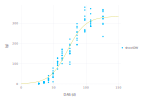

In [8]:
p = visualize(corn, :DAS, :shootDW; xlim = (0, 150))
visualize!(p, Logistic, :t, :W; config = lc, stop = 150u"d", kind = :line)

Here is an equivalent one-line version using `visualize(<DataFrame>, <System>, <x>, <y>; <simulate() options>.., <plot() options>..)`.

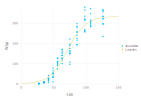

In [9]:
visualize(corn, Logistic, :DAS => :t, :shootDW => :W; config  = lc, stop = 150u"d", xlim = (0, 150))

Another form of `visualize(<DataFrame>, <System>, <y>; index=<..>, <simulate() options>.., <plot() options>..)` provides an 1:1 plot with observation against model estimation.

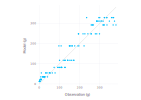

In [10]:
visualize(corn, Logistic, :shootDW => :W; index = :DAS => :t, config = lc, stop = 150u"d")

### What if we don't need to calibrate all parameters at the same time?

Sometimes we may not need or wish to calibrate all parameters in a model at the same time. It may be preferable to determine a parameter value based on the literature or prior knowledge instead of going through calibration process in some cases especially if those prior values have solid biological ground and data are limited. For example, it is relatively simple to determine the seed mass of corn before planting. Here, we will use seed mass ($W_0$) of 0.275g based on our prior knowledge of the mass of a corn kernel.  This will help us reduce the number of prameters to calibrate. This might sacrifice the fitness (e.g., rmse) but that's ok and we can determine how much fitness is lost, and whether it was worth it. There could be multiple ways to do this. Let's think about how we can achieve this in `Cropbox`.

In [12]:
lc1 = calibrate(Logistic, corn;
index = :DAS => :t,
target = :shootDW => :W,
parameters = Logistic => (;
    r = (0, 1),
    W0 = #= .. =#,
    Wf = (0, 500),
),
stop = 150u"d",
metric = :rmse,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 5001 steps and 5.35 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 934.07
Function evals per second = 869.26
Improvements/step = 0.27340
Total function evaluations = 4654


Best candidate found: [0.101545, 0.275, 312.61]

Fitness: 34.122577487



Config for 1 system:
  Logistic
    r  = 0.101545 d^-1
    W0 = 0.275 g
    Wf = 312.61 g

### Gompertz Equation

- Eqn 3.4.

$$
W = W_0 \exp \left[ \frac{r_0}{\alpha} (1 - e^{-\alpha t}) \right]
$$

- Table 3.1.

| Symbol | Value | Units | Description |
| :- | :- | :- | :- |
| $t$ | - | $\mathrm{d}$ | Time unit used in the model |
| $r_0$ | - | $\mathrm{g}$ $\mathrm{g^{-1}}$ $\mathrm{d^{-1}}$ | Initial intrinsic growth rate before loss of efficiency |
| $W_0$ | - | $\mathrm{g}$ | Seed mass or initial biomass |
| $\alpha$ | - | $\mathrm{d^{-1}}$ | Decay rate of the growth efficiency over time |
| $W$ | - | $\mathrm{g}$ | Whole-plant biomass as dry matter (state variable) |

In [11]:
@system Gompertz(Controller) begin
    t(context.clock.time) ~ track(u"d")
    
    #= .. =#: initial_intrinsic_growth_rate ~ preserve(parameter, u"g/g/d")
    #= .. =#: initial_biomass               ~ preserve(parameter, u"g")
    #= .. =#: growth_decay_rate             ~ preserve(parameter, u"d^-1")
    
    W(#= .. =#): biomass => begin
        #= .. =#
    end ~ track(u"g")
end

Gompertz

In [12]:
gc = calibrate(Gompertz, corn;
    index = #= .. =#,
    target = #= .. =#,
    parameters = Gompertz => (;
        r0 = (0, 1),
        W0 = (0, 10),
        α = (0, 1),
    ),
    stop = 150u"d",
    metric = :rmse,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 5001 steps and 8.28 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 603.72
Function evals per second = 615.55
Improvements/step = 0.17400
Total function evaluations = 5099


Best candidate found: [0.140685, 1.40549, 0.0243021]

Fitness: 36.177840154



Config for 1 system:
  Gompertz
    r0 = 0.140685 d^-1
    W0 = 1.40549 g
    α  = 0.0243021 d^-1

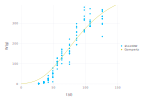

In [13]:
visualize(corn, Gompertz, #= .. =#, #= .. =#; config = #= .. =#, stop = 150u"d", xlim = (0, 150))

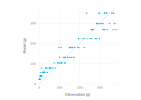

In [14]:
visualize(corn, Gompertz, :shootDW => :W; index = :DAS => :t, config = gc, stop = 150u"d")

### Evaluation

Cropbox provides `evaluate()` function, which is in a similart form to `calibrate()`, for calculating a measure of error between observation input and simulation output. We can specify an arbitrary metric function in `metric` option that accepts a list of estimated values (`E`) and corresponding observed values (`O`) and returns a meausre of error.

#### Root Mean Square Error (RMSE)

- Eqn 3.1.

$$
\mathrm{RMSE} = \sqrt{\frac{\sum_{i=1}^N (\hat{y}_i - y_i)^2}{N}}
$$

RMSE can be defined by a simple function like this.

In [15]:
rmse(E, O) = √mean((E .- O).^2)

rmse (generic function with 1 method)

Then call `evaluate()` with our `rmse()` function to calculate RMSE from our simulation.

In [16]:
evaluate(Logistic, corn;
    config = lc,
    index = :DAS => :t,
    target = :shootDW => :W,
    stop = 150u"d",
    metric = rmse,
)

30.59909529863296 g

Actually, Cropbox already has an implementation of commonly used metric functions including RMSE and EF. They are specified by pre-defined symbols (*i.e.* `:rmse` for RMSE, `:ef` for EF).

In [17]:
evaluate(Logistic, corn;
    config = lc,
    index = :DAS => :t,
    target = :shootDW => :W,
    stop = 150u"d",
    metric = :rmse,
)

30.59909529863296 g

In [18]:
evaluate(Gompertz, corn;
    config = gc,
    index = :DAS => :t,
    target = :shootDW => :W,
    stop = 150u"d",
    metric = :rmse,
)

36.177840154297606 g

Note that RMSE shares the same units (`g`) with the `target` variable which is shoot biomass (`shootDW` column in the dataset mapped to the variable `W` of the model) in this example.

Also beware that what we just did above was not a proper **validation** of calibrated model since the dataset we used for calibration was used again for calculating a measure of error. In other words, we were just looking at the fitness of calibration itself. For validation, we need another dataset independent of calibration.

#### Model Efficiency (EF)

- Eqn 3.2.

$$
\mathrm{EF} = 1 - \frac{\sum_i (\hat{y}_i - y_i)^2}{\sum_i (y_i - \bar{y})^2}
$$

Model efficiency (EF), or more specficially, Nash-Sutcliffe model efficiency coefficient (NSE) can be defined in a similar way.

In [19]:
ef(E, O) = 1 - sum((E .- O).^2) / sum((O .- mean(O)).^2)

ef (generic function with 1 method)

In [20]:
evaluate(Logistic, corn;
    config = lc,
    index = :DAS => :t,
    target = :shootDW => :W,
    stop = 150u"d",
    metric = :ef,
)

0.9382776419552395

In [21]:
evaluate(Gompertz, corn;
    config = gc,
    index = :DAS => :t,
    target = :shootDW => :W,
    stop = 150u"d",
    metric = :ef,
)

0.9137199062614062

The maximum value of EF is 1 which indicates a perfect model. When EF is zero, the model has the same predictive power as mean of observations. A negative value of EF indicates the model is worse than the observation mean.

### More Calibrations

Let's apply the same calibration process to other parts: stem, leaf, and ear.

#### Stem (`StemDW`)

In [22]:
lc_stem = calibrate(Logistic, corn;
    index = #= .. =#,
    target = #= .. =#,
    parameters = Logistic => (;
        r = #= .. =#,
        W0 = #= .. =#,
        Wf = #= .. =#,
    ),
    stop = 150u"d",
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 5001 steps and 8.26 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 605.52
Function evals per second = 618.35
Improvements/step = 0.20380
Total function evaluations = 5107


Best candidate found: [0.238022, 0.000534486, 91.003]

Fitness: 12.185587600



Config for 1 system:
  Logistic
    r  = 0.238022 d^-1
    W0 = 0.000534486 g
    Wf = 91.003 g

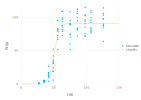

In [23]:
visualize(corn, Logistic, #= .. =#, #= .. =#; config = #= .. =#, stop = 150u"d", xlim = (0, 150))

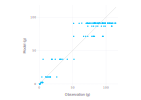

In [24]:
visualize(corn, Logistic, #= .. =#; index = #= .. =#, config = #= .. =#, stop = 150u"d")

In [25]:
evaluate(Logistic, corn;
    config = #= .. =#,
    index = #= .. =#,
    target = #= .. =#,
    stop = 150u"d",
    metric = :rmse,
)

12.185587600223878 g

#### Leaf (`LfDW`)

In [26]:
lc_leaf = calibrate(Logistic, corn;
    index = #= .. =#,
    target = #= .. =#,
    parameters = Logistic => (;
        r = #= .. =#,
        W0 = #= .. =#,
        Wf = #= .. =#,
    ),
    stop = 150u"d",
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 5001 steps and 8.08 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 619.11
Function evals per second = 632.97
Improvements/step = 0.19960
Total function evaluations = 5113


Best candidate found: [0.200213, 0.00298419, 30.1169]

Fitness: 4.146101229



Config for 1 system:
  Logistic
    r  = 0.200213 d^-1
    W0 = 0.00298419 g
    Wf = 30.1169 g

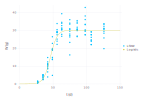

In [27]:
visualize(corn, Logistic, #= .. =#, #= .. =#; config = #= .. =#, stop = #= .. =#, xlim = (0, 150))

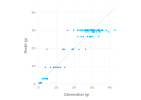

In [28]:
visualize(corn, Logistic, #= .. =#; index = #= .. =#, config = #= .. =#, stop = #= .. =#)

In [29]:
evaluate(Logistic, corn;
    config = #= .. =#,
    index = #= .. =#,
    target = #= .. =#,
    stop = #= .. =#,
    metric = :rmse,
)

4.146101229181499 g

#### Ear (`EarDW`)

In [30]:
lc_ear = #= .. =#

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 5001 steps and 8.16 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 613.16
Function evals per second = 624.56
Improvements/step = 0.18360
Total function evaluations = 5094


Best candidate found: [0.133581, 0.00313773, 204.922]

Fitness: 15.004653187



Config for 1 system:
  Logistic
    r  = 0.133581 d^-1
    W0 = 0.00313773 g
    Wf = 204.922 g

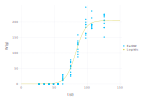

In [31]:
visualize(corn, Logistic, #= .. =#, #= .. =#; config = lc_ear, #= .. =#, xlim = (0, 150))

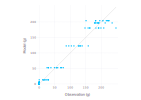

In [32]:
visualize(corn, Logistic, #= .. =#; index = #= .. =#, config = lc_ear, #= .. =#)

In [33]:
evaluate(Logistic, corn;
    config = lc_ear,
    #= .. =#,
    #= .. =#,
    stop = #= .. =#,
    metric = :rmse,
)

15.00465318723227 g

## Ex 3.2.

In this exercise, we will calibrate the Lotka-Volterra equations to fit the data of lynx and hare populations collected by the Hudson Bay Company.

1. In the previous exercises in Unit 2, we examined the behavior of the Lotoka-Volterra equations. Recall the parameter values for density independent L-V equations that you estimated by visual examination and plot the predator-prey dynamics based on those values.
2. Apply an optimization method (i.e., DE) to find the set of parameter values that minimizes the residuals. 
3. Compare the model predictions based on two different parameter sets (visual vs. DE calibrated) against the observations and test their goodness of fit (RMSE) and model efficiency.
4. Plot predicted vs observed values for both models and compare, and interpret the comparisons.

### Dataset

This dataset contains the number of pelts (in thousands) of Canadian lynx and snowshow hare traded by the Hudson Bay Trading Company in Canada from 1845 to 1935.

In [34]:
pelts = CSV.read("hare_lynx_data.csv", DataFrame) |> unitfy

91×3 DataFrame
 Row │ Year       Hare     Lynx    
     │ Quantity…  Float64  Float64 
─────┼─────────────────────────────
   1 │   1845 yr    19.58    30.09
   2 │   1846 yr    19.6     45.15
   3 │   1847 yr    19.61    49.15
   4 │   1848 yr    11.99    39.52
   5 │   1849 yr    28.04    21.23
   6 │   1850 yr    58.0      8.42
   7 │   1851 yr    74.6      5.56
   8 │   1852 yr    75.09     5.08
   9 │   1853 yr    88.48    10.17
  10 │   1854 yr    61.28    19.6
  11 │   1855 yr    74.67    32.91
  ⋮  │     ⋮         ⋮        ⋮
  82 │   1926 yr     4.64    53.99
  83 │   1927 yr     2.54    52.25
  84 │   1928 yr     1.8     37.7
  85 │   1929 yr     2.39    19.14
  86 │   1930 yr     4.23     6.98
  87 │   1931 yr    19.52     8.31
  88 │   1932 yr    82.11    16.01
  89 │   1933 yr    89.76    24.82
  90 │   1934 yr    81.66    29.7
  91 │   1935 yr    15.76    35.4
                    70 rows omitted

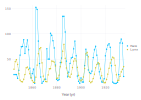

In [35]:
visualize(pelts, :Year, [:Hare, :Lynx], kind = :scatterline)

Among them, data from 1900 to 1920 has been widely used as an example for demonstrating Lotka-Volterra model as it clearly shows a pattern that predator population closely follows a trajectory of prey population and vice versa.

Let's make a subset of the data by using [DataFramesMeta.jl](https://github.com/JuliaData/DataFramesMeta.jl) which provides convenient macros like `@subset` to extract a subset of data frame in regards with certain conditions.

In [36]:
hare_lynx = @subset(pelts, 1900u"yr" .<= :Year .<= 1920u"yr")

21×3 DataFrame
 Row │ Year       Hare     Lynx    
     │ Quantity…  Float64  Float64 
─────┼─────────────────────────────
   1 │   1900 yr    12.82     7.13
   2 │   1901 yr     4.72     9.47
   3 │   1902 yr     4.73    14.86
   4 │   1903 yr    37.22    31.47
   5 │   1904 yr    69.72    60.57
   6 │   1905 yr    57.78    63.51
   7 │   1906 yr    28.68    54.7
   8 │   1907 yr    23.37     6.3
   9 │   1908 yr    21.54     3.41
  10 │   1909 yr    26.34     5.44
  11 │   1910 yr    53.1     11.65
  12 │   1911 yr    68.48    20.35
  13 │   1912 yr    75.58    32.88
  14 │   1913 yr    57.92    39.55
  15 │   1914 yr    40.97    43.36
  16 │   1915 yr    24.95    40.83
  17 │   1916 yr    12.59    30.36
  18 │   1917 yr     4.97    17.18
  19 │   1918 yr     4.5      6.82
  20 │   1919 yr    11.21     3.19
  21 │   1920 yr    56.6      3.52

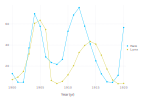

In [37]:
visualize(hare_lynx, :Year, [:Hare, :Lynx], kind = :scatterline)

### Model

- Eqn 3.5.

$$
\begin{align}
\frac{dN}{dt} &= bN - aNP \\
\frac{dP}{dt} &= caNP - mP \\
\end{align}
$$

- Table 3.1.

| Symbol | Value | Units | Description |
| :- | :- | :- | :- |
| $t$ | - | $\mathrm{yr}$ | Time unit used in the model |
| $N$ | - | - | Prey population as number of individuals (state variable) |
| $P$ | - | - | Predator population as number of individuals (state variable) |
| $N_0$ | - | - | Initial prey population |
| $P_0$ | - | - | Initial predator population |
| $b$ | - | $\mathrm{yr^{-1}}$ | Per capital birth rate that defines the intrinsic growth rate of prey population |
| $a$ | - | $\mathrm{yr^{-1}}$ | Attack rate or predation rate |
| $c$ | - | - | Conversion efficiency of an eaten prey into new predator; predator's reproduction efficiency per prey consumed) |
| $m$ | - | $\mathrm{yr^{-1}}$ | Mortality rate of predator population |

Here is `LotkaVolterra` system we created. You may have noticed new parameter `y0` for setting the start year and a new variable `y` for keeping track of the year in the same way as we have in the dataset.

In [38]:
@system LotkaVolterra(Controller) begin
    t(context.clock.time) ~ track(u"yr")
    y(t): year            ~ track::Int(u"yr", round)
    
    N(N, P, b, a):    prey_population     =>     b*N - a*N*P ~ accumulate(init = N0)
    P(N, P, c, a, m): predator_population => c*a*N*P -   m*P ~ accumulate(init = P0)
    
    N0: prey_initial_population     ~ preserve(parameter)
    P0: predator_initial_population ~ preserve(parameter)
    
    b: prey_birth_rate            ~ preserve(parameter, u"yr^-1")
    a: predation_rate             ~ preserve(parameter, u"yr^-1")
    c: predator_reproduction_rate ~ preserve(parameter)
    m: predator_mortality_rate    ~ preserve(parameter, u"yr^-1")
end

LotkaVolterra

For reference, here is the default set of parameters we are going to use.

In [39]:
lvc = @config (
    :Clock => (;
        init = 1900u"yr",
        step = 1u"d",
    ),
    LotkaVolterra => (;
        b = 0.6,
        a = 0.02,
        c = 0.5,
        m = 0.5,
        N0 = 20,
        P0 = 30,
    ),
)

Config for 2 systems:
  Clock
    init = 1900 yr
    step = 1 d
  LotkaVolterra
    b  = 0.6 yr^-1
    a  = 0.02 yr^-1
    c  = 0.5
    m  = 0.5 yr^-1
    N0 = 20
    P0 = 30

### Calibration

We again use `calibrate()` function to get calibration done. A notable difference is that now we have to fit our parameters in regards with two `target` variables, `N` and `P` which are provided in a list of mappings. Also note that the use of mapping for `index` variable for `Year` with uppercase in the dataset and `year` with lowercase in the model. The configuration we just created (`lvc`) will be used as a baseline `config` for setting up default time step (`context.clock.step`) and starting year (`y0`). The range of parameter values are chosen arbitrarily large to cover dynamics we saw in the dataset.

We use `snap` option to explicitly indicate that the output should be recorded by 365 days interval to avoid excessive rows in the data frame causing unnecessary slowdown. Note we use `365u"d"` instead of `1u"yr"` which is technically equivalent to `365.25u"d"` following the convention in astronomy.

#### 20 years

In [40]:
lvcc = calibrate(LotkaVolterra, hare_lynx;
    index = :Year => :y,
    target = [:Hare => :N, :Lynx => :P],
    config = lvc,
    parameters = LotkaVolterra => (;
        b = (0, 2),
        a = (0, 2),
        c = (0, 2),
        m = (0, 2),
        N0 = (0, 100),
        P0 = (0, 100),
    ),
    stop = 20u"yr",
    snap = 365u"d",
)

Starting optimization with optimizer BlackBoxOptim.BorgMOEA{BlackBoxOptim.EpsBoxDominanceFitnessScheme{2, Float64, true, typeof(mean)}, BlackBoxOptim.ProblemEvaluator{Tuple{Float64, Float64}, BlackBoxOptim.IndexedTupleFitness{2, Float64}, BlackBoxOptim.EpsBoxArchive{2, Float64, BlackBoxOptim.EpsBoxDominanceFitnessScheme{2, Float64, true, typeof(mean)}}, BlackBoxOptim.FunctionBasedProblem{Cropbox.var"#cost#484"{Vector{Config}, Cropbox.var"#config#483"{Vector{Union{Nothing, Unitful.FreeUnits{(yr^-1,), 𝐓^-1, nothing}}}, Vector{Any}}, Cropbox.var"#residual#481"{Pair{Symbol, Symbol}, Vector{Pair{Symbol, Symbol}}, Base.Pairs{Symbol, Unitful.Quantity{Int64, 𝐓}, Tuple{Symbol, Symbol}, NamedTuple{(:stop, :snap), Tuple{Unitful.Quantity{Int64, 𝐓, Unitful.FreeUnits{(yr,), 𝐓, nothing}}, Unitful.Quantity{Int64, 𝐓, Unitful.FreeUnits{(d,), 𝐓, nothing}}}}}, DataType, DataFrame, Vector{Symbol}, Cropbox.var"#snap#480"{Tuple{Symbol}, Vector{Tuple{Unitful.Quantity{Int64, 𝐓, Unitful.FreeUnits{(yr,), 𝐓, noth

Config for 1 system:
  LotkaVolterra
    b  = 1.94788 yr^-1
    a  = 0.0693619 yr^-1
    c  = 0.181173
    m  = 0.348524 yr^-1
    N0 = 5.82954
    P0 = 24.4138

Let's make a comparison plot between observations and model predictions.

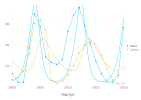

In [41]:
p = visualize(hare_lynx, :Year, [:Hare, :Lynx]; kind = :scatterline)
visualize!(p, LotkaVolterra, :t, [:N, :P];
    config = (lvc, lvcc),
    stop = 20u"yr",
    kind = :line,
    colors = [1, 2],
    names = [],
)

`evaluate()` function returns a tuple of two values for the given metric where each value corresponds to an indivdiual target variable. For example, the first value would be an RMSE for hare population and the second value would be an RMSE for lynx population.

In [42]:
evaluate(LotkaVolterra, hare_lynx;
    index = :Year => :y,
    target = [:Hare => :N, :Lynx => :P],
    config = (lvc, lvcc),
    stop = 20u"yr",
    snap = 365u"d",
    metric = :rmse,
)

(16.071795474212482, 14.637079278059883)

In [43]:
evaluate(LotkaVolterra, hare_lynx;
    index = :Year => :y,
    target = [:Hare => :N, :Lynx => :P],
    config = (lvc, lvcc),
    stop = 20u"yr",
    snap = 365u"d",
    metric = :ef,
)

(0.5301100133446961, 0.43311076130770776)

#### 90 years

As an exercise, let's try calibration with the full dataset for simulating 90 years of period. It'll be much harder as the dataset is more noisy and doesn't show a clear pattern. How does the modeling output look like?

In [44]:
lvc0 = @config lvc, :Clock => :init => 1845u"yr"

Config for 2 systems:
  Clock
    init = 1845 yr
    step = 1 d
  LotkaVolterra
    b  = 0.6 yr^-1
    a  = 0.02 yr^-1
    c  = 0.5
    m  = 0.5 yr^-1
    N0 = 20
    P0 = 30

In [45]:
lvcc0 = calibrate(LotkaVolterra, pelts;
    index = #= .. =#
    target = [#= .. =#, #= .. =#],
    config = lvc0,
    parameters = LotkaVolterra => (;
        b = #= .. =#,
        a = #= .. =#,
        c = #= .. =#,
        m = #= .. =#,
        N0 = #= .. =#,
        P0 = #= .. =#,
    ),
    stop = #= .. =#,
    snap = 365u"d",
)

Starting optimization with optimizer BlackBoxOptim.BorgMOEA{BlackBoxOptim.EpsBoxDominanceFitnessScheme{2, Float64, true, typeof(mean)}, BlackBoxOptim.ProblemEvaluator{Tuple{Float64, Float64}, BlackBoxOptim.IndexedTupleFitness{2, Float64}, BlackBoxOptim.EpsBoxArchive{2, Float64, BlackBoxOptim.EpsBoxDominanceFitnessScheme{2, Float64, true, typeof(mean)}}, BlackBoxOptim.FunctionBasedProblem{Cropbox.var"#cost#484"{Vector{Config}, Cropbox.var"#config#483"{Vector{Union{Nothing, Unitful.FreeUnits{(yr^-1,), 𝐓^-1, nothing}}}, Vector{Any}}, Cropbox.var"#residual#481"{Pair{Symbol, Symbol}, Vector{Pair{Symbol, Symbol}}, Base.Pairs{Symbol, Unitful.Quantity{Int64, 𝐓}, Tuple{Symbol, Symbol}, NamedTuple{(:stop, :snap), Tuple{Unitful.Quantity{Int64, 𝐓, Unitful.FreeUnits{(yr,), 𝐓, nothing}}, Unitful.Quantity{Int64, 𝐓, Unitful.FreeUnits{(d,), 𝐓, nothing}}}}}, DataType, DataFrame, Vector{Symbol}, Cropbox.var"#snap#480"{Tuple{Symbol}, Vector{Tuple{Unitful.Quantity{Int64, 𝐓, Unitful.FreeUnits{(yr,), 𝐓, noth

Config for 1 system:
  LotkaVolterra
    b  = 0.366494 yr^-1
    a  = 0.013843 yr^-1
    c  = 1.87921
    m  = 1.20608 yr^-1
    N0 = 68.9153
    P0 = 31.8054

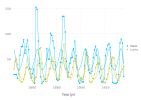

In [46]:
p = visualize(pelts, #= .. =#, #= .. =#; kind = :scatterline)
visualize!(p, LotkaVolterra, #= .. =#, #= .. =#;
    config = (lvc0, lvcc0),
    stop = 90u"yr",
    kind = :line,
    colors = [1, 2],
    names = [],
)

In [47]:
evaluate(LotkaVolterra, pelts;
    index = #= .. =#,
    target = #= .. =#,
    config = (lvc0, lvcc0),
    stop = #= .. =#,
    snap = 365u"d",
    metric = :rmse,
)

(31.366564604288023, 11.598784055046776)

In [48]:
evaluate(LotkaVolterra, pelts;
    index = #= .. =#,
    target = #= .. =#,
    config = (lvc0, lvcc0),
    stop = #= .. =#,
    snap = 365u"d",
    metric = :ef,
)

(0.24817427640461276, 0.6177610772962152)

## HW 3.3 Template

Calibrate the *density-dependent* Lotka-Volterra predator-prey model using the observational data. How do the parameter estimates compare with that of density independent model? How do the model behavior compare? 

### Model

- Eqn 3.6.

$$
\begin{align}
\frac{dN}{dt} &= bN-\frac{b}{K}N^2-aNP \\
\frac{dP}{dt} &= caNP-mP \\
\end{align}
$$

- Table 3.1.

| Symbol | Value | Units | Description |
| :- | :- | :- | :- |
| $t$ | - | $\mathrm{yr}$ | Time unit used in the model |
| $N$ | - | - | Prey population as number of individuals (state variable) |
| $P$ | - | - | Predator population as number of individuals (state variable) |
| $N_0$ | - | - | Initial prey population |
| $P_0$ | - | - | Initial predator population |
| $b$ | - | $\mathrm{yr^{-1}}$ | Per capital birth rate that defines the intrinsic growth rate of prey population |
| $a$ | - | $\mathrm{yr^{-1}}$ | Attack rate or predation rate |
| $c$ | - | - | Conversion efficiency of an eaten prey into new predator; predator's reproduction efficiency per prey consumed) |
| $m$ | - | $\mathrm{yr^{-1}}$ | Mortality rate of predator population |
| $K$ | - | - | Carrying capacity of the system for prey population |

In case we want, here is `LotkaVolterraDD` system based on the new `LotkaVolterra`. There is no change in the model specification itself.

In [49]:
@system LotkaVolterraDD(LotkaVolterra, Controller) begin
    N(#= .. =#): prey_population => begin
        #= .. =#
    end ~ #= .. =#(#= .. =#)
    
    K: carrying_capacity ~ #= .. =#(#= .. =#)
end

LotkaVolterraDD

In [50]:
lvddc = @config (lvc0,
    LotkaVolterraDD => (;
        K = 1000,
    ),
)

Config for 3 systems:
  Clock
    init = 1845 yr
    step = 1 d
  LotkaVolterra
    b  = 0.6 yr^-1
    a  = 0.02 yr^-1
    c  = 0.5
    m  = 0.5 yr^-1
    N0 = 20
    P0 = 30
  LotkaVolterraDD
    K = 1000

### Calibration

As an extra, here is the same calibration done for density-dependent version of the model `LotkaVolterraDD`.

In [51]:
lvddcc = calibrate(LotkaVolterraDD, pelts;
    index = :Year => :year,
    target = [:Hare => :N, :Lynx => :P],
    config = lvddc,
    parameters = LotkaVolterraDD => (;
        b = (0, #= .. =#),
        a = (0, #= .. =#),
        c = (0, #= .. =#),
        m = (0, #= .. =#),
        N0 = (0, #= .. =#),
        P0 = (0, #= .. =#),
        K = (0, #= .. =#),
    ),
    stop = 90u"yr",
    snap = 365u"d",
)

Starting optimization with optimizer BlackBoxOptim.BorgMOEA{BlackBoxOptim.EpsBoxDominanceFitnessScheme{2, Float64, true, typeof(mean)}, BlackBoxOptim.ProblemEvaluator{Tuple{Float64, Float64}, BlackBoxOptim.IndexedTupleFitness{2, Float64}, BlackBoxOptim.EpsBoxArchive{2, Float64, BlackBoxOptim.EpsBoxDominanceFitnessScheme{2, Float64, true, typeof(mean)}}, BlackBoxOptim.FunctionBasedProblem{Cropbox.var"#cost#484"{Vector{Config}, Cropbox.var"#config#483"{Vector{Union{Nothing, Unitful.FreeUnits{(yr^-1,), 𝐓^-1, nothing}}}, Vector{Any}}, Cropbox.var"#residual#481"{Pair{Symbol, Symbol}, Vector{Pair{Symbol, Symbol}}, Base.Pairs{Symbol, Unitful.Quantity{Int64, 𝐓}, Tuple{Symbol, Symbol}, NamedTuple{(:stop, :snap), Tuple{Unitful.Quantity{Int64, 𝐓, Unitful.FreeUnits{(yr,), 𝐓, nothing}}, Unitful.Quantity{Int64, 𝐓, Unitful.FreeUnits{(d,), 𝐓, nothing}}}}}, DataType, DataFrame, Vector{Symbol}, Cropbox.var"#snap#480"{Tuple{Symbol}, Vector{Tuple{Unitful.Quantity{Int64, 𝐓, Unitful.FreeUnits{(yr,), 𝐓, noth

Config for 1 system:
  LotkaVolterraDD
    b  = 0.820208 yr^-1
    a  = 0.0304577 yr^-1
    c  = 0.413718
    m  = 0.54783 yr^-1
    N0 = 44.7084
    P0 = 62.2367
    K  = 843.726

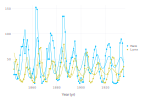

In [52]:
p = visualize(pelts, :Year, [:Hare, :Lynx], kind = :scatterline)
visualize!(p, LotkaVolterraDD, :t, [:N, :P];
    config = (lvddc, lvddcc),
    stop = 90u"yr",
    kind = :line,
    colors = [1, 2],
    names = [],
)

In [53]:
evaluate(LotkaVolterraDD, pelts;
    index = :Year => :year,
    target = [:Hare => :N, :Lynx => :P],
    config = (lvddc, lvddcc),
    stop = 90u"yr",
    snap = 365u"d",
    metric = :rmse,
)

(30.239265251875157, 14.68768790296256)

In [54]:
evaluate(LotkaVolterraDD, pelts;
    index = :Year => :year,
    target = [:Hare => :N, :Lynx => :P],
    config = (lvddc, lvddcc),
    stop = 90u"yr",
    snap = 365u"d",
    metric = :ef,
)

(0.3012436961811492, 0.3870615665435546)